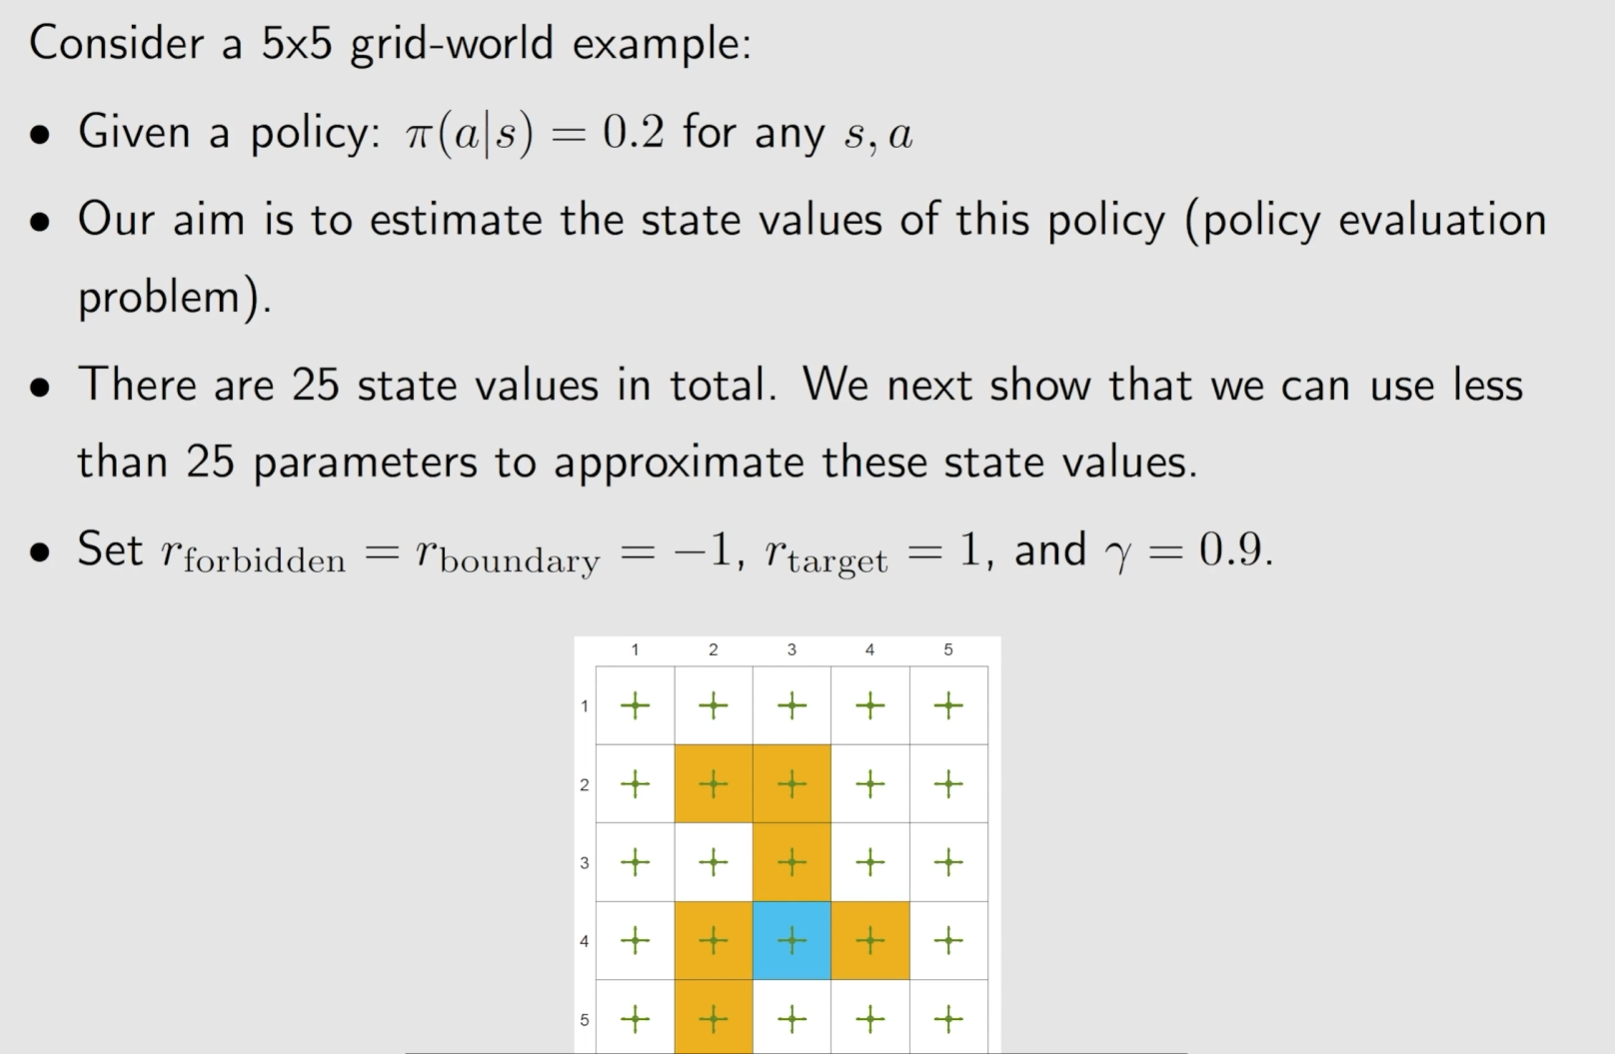


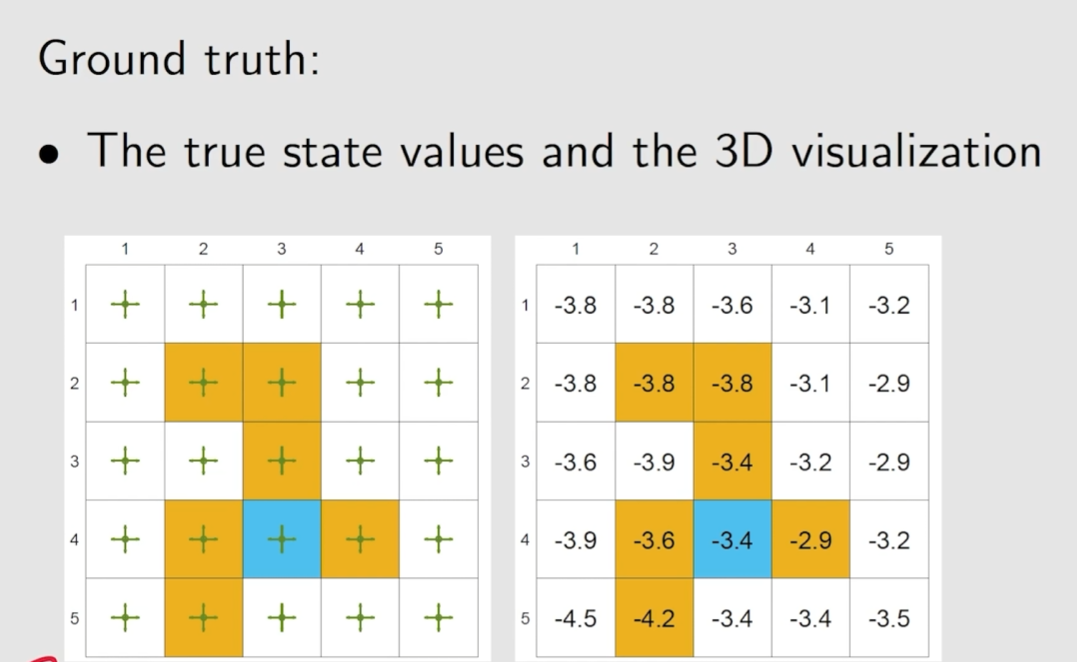

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from generate_episode import gen_multi_episodes, gen_episode
%matplotlib qt

In [24]:
def calculate_q_hat_and_grad(s, a, w, phi_order=4):
    # v_hat = φ(s).T @ w
    x, y = s
    z = a
    phi_dic = {4:[1, x, y, z], 10:[1, x, y, z, x**2, y**2, z**2, x*y, x*z, y*z], 
               20:[1, x, y, z, 
                   x**2, y**2, z**2, x*y, x*z, y*z, x**3, y**3, z**3, 
                   (x**2)*y, x*(y**2), (x**2)*z, x*(z**2),
                   (y**2)*z, y*(z**2),
                    x*y*z]}
    phi_s = np.asarray(phi_dic[phi_order]).reshape(-1,1)
    return phi_s.T @ w, phi_s


def get_num(item):
    return int(item.split("_")[-1])

# 把状态一维索引转换为二维索引, i,j = (1~25)
def trans_state2ij(item, grid_edge_length):
    state = get_num(item)
    mod = state % grid_edge_length
    j = mod if mod != 0 else 5
    i = int(((state - j) / grid_edge_length) + 1)
    return (i, j)


def visual_3d(data, z_min=-5, z_max=-2):
    # 假设 pred 已经有数据
    # pred = np.random.rand(5, 5)  # 示例数据替代你的 pred 数组

    # 生成坐标网格（假设是 5x5 的二维数组）
    
    
    x = np.arange(0, 5)
    y = np.arange(0, 5)
    X, Y = np.meshgrid(x, y)  # 生成网格坐标
    Z = data  # 你的二维数组

    # 创建三维画布
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制表面图
    surf = ax.plot_surface(Y, X, Z, cmap='viridis', edgecolor='k', linewidth=0.5)

    # 固定z轴取值范围
    ax.set_zlim(z_min, z_max)

    # 添加颜色条和标签
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    ax.set_xlabel('row')
    ax.set_ylabel('column')
    ax.set_zlabel('Value')
    ax.set_title('3D Surface Plot')

    # 启用交互模式，允许图表旋转
    plt.ion()

    # 显示图形
    plt.show()

    # 保持图表直到关闭窗口
    plt.ioff()
    
def visual_error(x, y, alpha):
    # %matplotlib inline
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot()
    ax.plot(x, y, label=f"TD-Linear:α={alpha}")
    ax.set_xlabel("Episode Index")
    ax.set_ylabel("State Value error(RMSE)")
    ax.legend()
    plt.show()

In [25]:
ground_truth = np.array([[-3.8, -3.8, -3.6, -3.1, -3.2],
                         [-3.8, -3.8, -3.8, -3.1, -2.9],
                         [-3.6, -3.9, -3.4, -3.2, -2.9],
                         [-3.9, -3.6, -3.4, -2.9, -3.2],
                         [-4.5, -4.2, -3.4, -3.4, -3.5]])
n_actions = 5
grid_edge_length = 5
n_state = ground_truth.size    
forbidden_state = [7 ,8, 13, 17, 19, 22] 
tgt_state = 18    
# pi's shape: (25, 5)
pi = np.zeros(shape=(n_state, n_actions)) + 0.2
r_forbid = -10
r_bound = -10
r_normal = 0
r_tgt = 1
gamma = 0.9

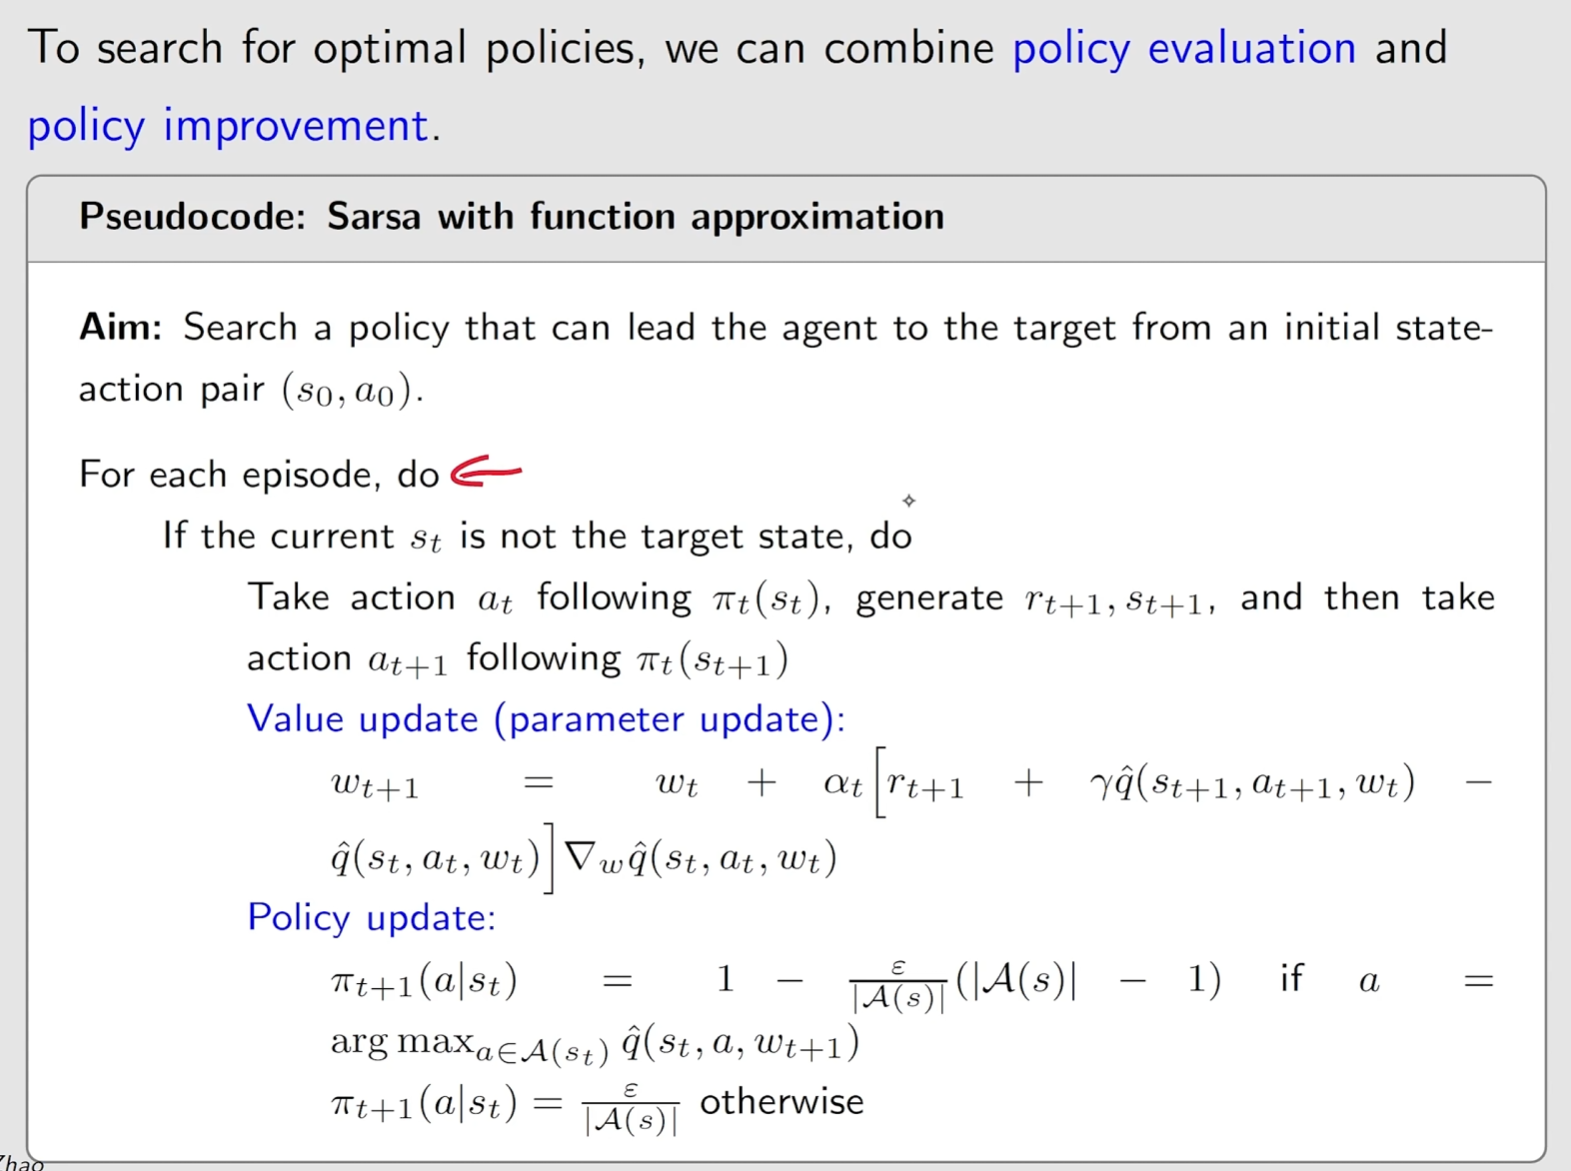 

In [26]:
eps = 0.2
1 - (eps/n_actions) * (n_actions - 1), eps / n_actions

(0.84, 0.04)

In [27]:
# eps-(0,1) eps越大，概率越均匀。0为greedy, 1为uniform
eps = 0.3
phi_order = 20
w = np.random.normal(size=(phi_order, 1))
alpha = 1e-4
error_ls = []
pi = np.zeros(shape=(n_state, n_actions)) + 0.2

# 找到一条从(0,0)到tgt的路径
for i in range(100):

    episode = gen_episode(pi=pi, episode_length=500, grid_edge_length=grid_edge_length, forbidden_state=forbidden_state, 
                        tgt_state=tgt_state, r_normal=r_normal, r_bound=r_bound, r_forbid=r_forbid, r_tgt=r_tgt, 
                        mode="sarsa", init_pos=(0,0), end_pos=(3,2))
    for j, trajectory in enumerate(episode):
        # value update
        s_t = trans_state2ij(trajectory[0], grid_edge_length)
        if s_t == tgt_state:
            break
        a_t = get_num(trajectory[1])
        r_next_t = get_num(trajectory[2])
        s_next_t = trans_state2ij(trajectory[3], grid_edge_length)
        a_next_t = get_num(trajectory[4])

        q_t_hat, q_t_grad= calculate_q_hat_and_grad(s_t, a_t, w, phi_order)
        q_next_t_hat, _ = calculate_q_hat_and_grad(s_next_t, a_next_t, w, phi_order)

        # w = w + (alpha/(j+1)) * q_t_grad * (r_next_t + gamma * q_next_t_hat - q_t_hat)
        w = w + alpha * q_t_grad * (r_next_t + gamma * q_next_t_hat - q_t_hat)
        
        # policy update
        max_q = -float("inf")
        best_a = -1
        for a in range(n_actions):
            q_hat, _ = calculate_q_hat_and_grad(s_t, a, w, phi_order)
            if max_q < q_hat:
                max_q = q_hat
                best_a = a

        pi[get_num(trajectory[0])-1, :] = eps / n_actions
        pi[get_num(trajectory[0])-1, best_a] = 1 - (eps/n_actions) * (n_actions - 1)
        
print(pi.argmax(1))

[2 2 3 3 4 2 3 3 4 4 0 4 4 0 0 0 4 0 0 4 0 4 4 0 0]


In [28]:
gen_episode(pi=pi, episode_length=1, grid_edge_length=grid_edge_length, forbidden_state=forbidden_state, 
                        tgt_state=tgt_state, r_normal=r_normal, r_bound=r_bound, r_forbid=r_forbid, r_tgt=r_tgt, mode="sarsa", init_pos=(0,0), end_pos=(3,2))

[('s0_1', 'a0_2', 'r1_0', 's1_6', 'a1_3'),
 ('s1_6', 'a1_3', 'r2_-10', 's2_6', 'a2_2'),
 ('s2_6', 'a2_2', 'r3_0', 's3_11', 'a3_0'),
 ('s3_11', 'a3_0', 'r4_0', 's4_6', 'a4_0'),
 ('s4_6', 'a4_0', 'r5_0', 's5_1', 'a5_2'),
 ('s5_1', 'a5_2', 'r6_0', 's6_6', 'a6_2'),
 ('s6_6', 'a6_2', 'r7_0', 's7_11', 'a7_3'),
 ('s7_11', 'a7_3', 'r8_-10', 's8_11', 'a8_0'),
 ('s8_11', 'a8_0', 'r9_0', 's9_6', 'a9_2'),
 ('s9_6', 'a9_2', 'r10_0', 's10_11', 'a10_0'),
 ('s10_11', 'a10_0', 'r11_0', 's11_6', 'a11_2'),
 ('s11_6', 'a11_2', 'r12_0', 's12_11', 'a12_2'),
 ('s12_11', 'a12_2', 'r13_0', 's13_16', 'a13_3'),
 ('s13_16', 'a13_3', 'r14_-10', 's14_16', 'a14_1'),
 ('s14_16', 'a14_1', 'r15_-10', 's15_17', 'a15_4'),
 ('s15_17', 'a15_4', 'r16_-10', 's16_17', 'a16_4'),
 ('s16_17', 'a16_4', 'r17_-10', 's17_17', 'a17_4'),
 ('s17_17', 'a17_4', 'r18_-10', 's18_17', 'a18_4'),
 ('s18_17', 'a18_4', 'r19_-10', 's19_17', 'a19_4'),
 ('s19_17', 'a19_4', 'r20_-10', 's20_17', 'a20_4'),
 ('s20_17', 'a20_4', 'r21_-10', 's21_17', 'a